### Assignment 3: CNN
Jake Giguere <giguere@bu.edu>

The goal of the assignment is to contruct an unique CNN to classify handwritten notes in sheet music.
This data can be found https://github.com/OMR-Research/muscima-pp/tree/master/v2.0/data/annotations

In [45]:
import os
import numpy as np
from mung.io import read_nodes_from_file

parse the data

In [81]:
# Base directory path
base_dir = 'muscima-pp-master/v1.0/data/cropobjects_withstaff/'

# Initialize an empty list to hold file paths
node_filenames = []

# Walk through the directory tree
for root, dirs, files in os.walk(base_dir):
    for file in files:
        # Check if the file has an XML extension
        if file.endswith('.xml'):
            # Construct the full file path
            full_path = os.path.join(root, file)
            # Verify the file exists
            if os.path.isfile(full_path):
                node_filenames.append(full_path)
            else:
                print(f"File not found: {full_path}")

# Read nodes from each XML file
docs = []
for f in node_filenames:
    try:
        nodes = read_nodes_from_file(f)
        docs.append(nodes)
    except Exception as e:
        print(f"Error processing file {f}: {e}")

# Output the number of documents processed
print(f"Number of documents processed: {len(docs)}")


Number of documents processed: 140


### Extract Nodes 

In [83]:
# Bear in mind that the outlinks are integers, only valid within the same document.
# Therefore, we define a function per-document, not per-dataset.

def extract_notes_from_doc(cropobjects):
    """Finds all ``(full-notehead, stem)`` pairs that form
    quarter or half notes. Returns two lists of Node tuples:
    one for quarter notes, one of half notes.

    :returns: quarter_notes, half_notes
    """
    _cropobj_dict = {c.id: c for c in cropobjects}

    notes = []
    for c in cropobjects:
        if (c.class_name == 'notehead-full') or (c.class_name == 'notehead-empty'):
            _has_stem = False
            _has_beam_or_flag = False
            stem_obj = None
            for o in c.outlinks:
                _o_obj = _cropobj_dict[o]
                if _o_obj.class_name == 'stem':
                    _has_stem = True
                    stem_obj = _o_obj
                elif _o_obj.class_name == 'beam':
                    _has_beam_or_flag = True
                elif _o_obj.class_name.endswith('flag'):
                    _has_beam_or_flag = True
            if _has_stem and (not _has_beam_or_flag):
                # We also need to check against quarter-note chords.
                # Stems only have inlinks from noteheads, so checking
                # for multiple inlinks will do the trick.
                if len(stem_obj.inlinks) == 1:
                    notes.append((c, stem_obj))

    quarter_notes = [(n, s) for n, s in notes if n.class_name == 'notehead-full']
    half_notes = [(n, s) for n, s in notes if n.class_name == 'notehead-empty']
    return quarter_notes, half_notes

qns_and_hns = [extract_notes_from_doc(cropobjects) for cropobjects in docs]

In [84]:
import itertools
qns = list(itertools.chain(*[qn for qn, hn in qns_and_hns]))
hns = list(itertools.chain(*[hn for qn, hn in qns_and_hns]))

len(qns), len(hns)

(4290, 1200)

### Create note images

In [85]:

def get_image(cropobjects, margin=1):
    """Paste the cropobjects' mask onto a shared canvas.
    There will be a given margin of background on the edges."""

    # Get the bounding box into which all the objects fit
    top = min([c.top for c in cropobjects])
    left = min([c.left for c in cropobjects])
    bottom = max([c.bottom for c in cropobjects])
    right = max([c.right for c in cropobjects])

    # Create the canvas onto which the masks will be pasted
    height = bottom - top + 2 * margin
    width = right - left + 2 * margin
    canvas = np.zeros((height, width), dtype='uint8')

    for c in cropobjects:
        # Get coordinates of upper left corner of the Node
        # relative to the canvas
        _pt = c.top - top + margin
        _pl = c.left - left + margin
        # We have to add the mask, so as not to overwrite
        # previous nonzeros when symbol bounding boxes overlap.
        canvas[_pt:_pt+c.height, _pl:_pl+c.width] += c.mask

    canvas[canvas > 0] = 1
    return canvas

qn_images = [get_image(qn) for qn in qns]
hn_images = [get_image(hn) for hn in hns]

### Save Images

In [134]:
from PIL import Image
import os
import numpy as np

# Create directories for saving images
os.makedirs('saved_images/quarter_notes', exist_ok=True)
os.makedirs('saved_images/half_notes', exist_ok=True)

# Save quarter note images
for i, img in enumerate(qn_images):
    img = (img * 255).astype(np.uint8)  # Scale to 0-255
    img_path = f'saved_images/quarter_notes/qn_{i}.png'
    Image.fromarray(img).save(img_path)

# Save half note images
for i, img in enumerate(hn_images):
    img = (img * 255).astype(np.uint8)  # Scale to 0-255
    img_path = f'saved_images/half_notes/hn_{i}.png'
    Image.fromarray(img).save(img_path)

print("Images saved successfully!")


Images saved successfully!


### Visualize images

In [88]:
import matplotlib.pyplot as plt

def show_mask(mask):
    plt.imshow(mask, cmap='gray', interpolation='nearest')
    plt.show()

def show_masks(masks, row_length=5):
    n_masks = len(masks)
    n_rows = n_masks // row_length + 1
    n_cols = min(n_masks, row_length)
    fig = plt.figure()
    for i, mask in enumerate(masks):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(mask, cmap='gray', interpolation='nearest')
    # Let's remove the axis labels, they clutter the image.
    for ax in fig.axes:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
    plt.show()

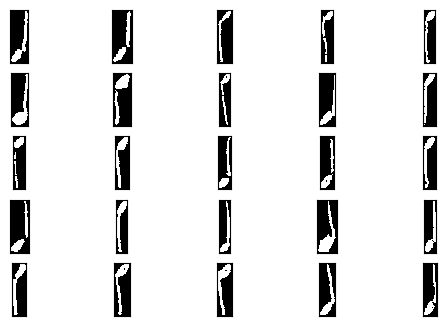

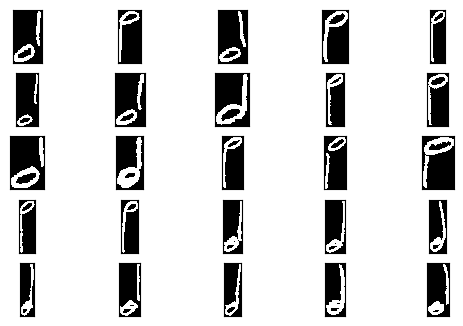

In [89]:
show_masks(qn_images[:25])
show_masks(hn_images[-25:])

### Resize to 40x10

In [77]:
from skimage.transform import resize

qn_resized = [resize(qn, (40, 10)) for qn in qn_images]
hn_resized = [resize(hn, (40, 10)) for hn in hn_images]

# And re-binarize, to compensate for interpolation effects
for qn in qn_resized:
    qn[qn > 0] = 1
for hn in hn_resized:
    hn[hn > 0] = 1

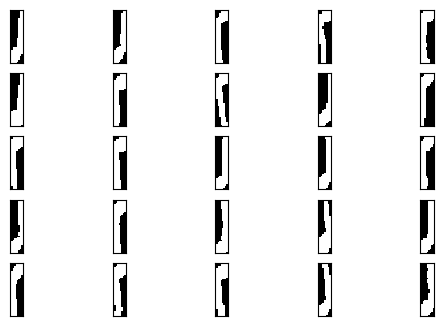

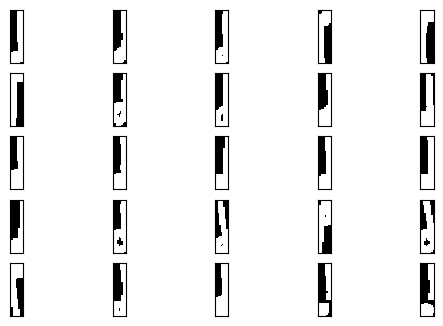

In [79]:
show_masks(qn_resized[:25])
show_masks(hn_resized[:25])

In [90]:
n_hn = len(hn_resized)
import random
random.shuffle(qn_resized)
qn_selected = qn_resized[:n_hn]

In [145]:
from PIL import Image
import os
import numpy as np
import keras

def load_images_from_directory(directory, label):
    """
    Load images from a directory and assign a label to each image.
    """
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.png'):
            img_path = os.path.join(directory, filename)
            image = Image.open(img_path).convert('L')  # Convert to grayscale
            image = image.resize((40,10), Image.Resampling.LANCZOS) #Found LANCZOS image through chatGPT
            image = np.array(image) / 255.0  # Normalize to [0, 1]
            images.append(image)
            labels.append(label)
    return images, labels

# Load quarter notes
qn_images, qn_labels = load_images_from_directory('saved_images/quarter_notes', label=1)

# Load half notes
hn_images, hn_labels = load_images_from_directory('saved_images/half_notes', label=0)

# Combine and prepare data
images = np.array(qn_images + hn_images)
labels = np.array(qn_labels + hn_labels)

# Add channel dimension to images
images = np.expand_dims(images, axis=-1)

# One-hot encode labels
from keras import utils
labels = utils.to_categorical(labels, num_classes=2)

# Split into training and testing datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=42, stratify=labels)

print(f"Training Data Shape: {X_train.shape}")
print(f"Test Data Shape: {X_test.shape}")


Training Data Shape: (4117, 10, 40, 1)
Test Data Shape: (1373, 10, 40, 1)


### Create output labels / Train Model

In [166]:
import tensorflow as tf
import keras
from keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np



target_size = (40, 10)  # Define the size for resizing

# Combine quarter and half note images and labels
notes = np.array(qn_resized + hn_resized)  
labels = np.array([1] * len(qn_resized) + [0] * len(hn_resized))

# One-hot encode labels
labels = keras.utils.to_categorical(labels, num_classes=2)

# Expand dimensions 
notes = np.expand_dims(notes, axis=-1)  

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(notes, labels, test_size=0.25, random_state=42, stratify=labels)


model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(2, activation='softmax')  # Output layer with 2 classes
])


# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# Save the model
model.save('music_notes_cnn.h5')


/Users/jakegiguere/Boston University/Fall24/CS767/Assignment3/cnn-env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_81 (Conv2D)              │ (None, 40, 10, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 20, 5, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 20, 5, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 10, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 10, 2, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_35 (Flatten)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,738 (1.60 MB)

 Trainable params: 420,738 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7733 - loss: 1.4776 - val_accuracy: 0.8471 - val_loss: 0.4132
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8480 - loss: 0.3945 - val_accuracy: 0.8738 - val_loss: 0.3335
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8587 - loss: 0.3437 - val_accuracy: 0.8774 - val_loss: 0.3159
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8744 - loss: 0.3215 - val_accuracy: 0.8847 - val_loss: 0.3089
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8761 - loss: 0.3109 - val_accuracy: 0.8847 - val_loss: 0.3071
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8769 - loss: 0.2989 - val_accuracy: 0.8823 - val_loss: 0.3363
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8709 - loss: 0.3122 - val_accuracy: 0.8786 - val_loss: 0.3060
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8862 - loss: 0.2757 - val_accu

Test Accuracy: 0.89


In [167]:
from keras import models
import numpy as np

# Load the trained model
model = models.load_model('music_notes_cnn.h5')
# Predict on test data
y_pred_probs = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class
y_true = np.argmax(y_test, axis=1)  # True class

# Print predictions for the first few samples
print("Predictions:", y_pred[:10])
print("True Labels:", y_true[:10])


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predictions: [1 1 1 1 1 1 1 1 1 1]
True Labels: [1 1 1 1 1 1 1 1 1 1]


In [168]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import numpy as np

# Predict on test data
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class
y_true = np.argmax(y_test, axis=1)  # True class

# Metrics
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Half Notes', 'Quarter Notes']))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
F1 Score: 0.93
Precision: 0.90
Recall: 0.96
Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

   Half Notes       0.82      0.62      0.70       300
Quarter Notes       0.90      0.96      0.93      1073

     accuracy                           0.89      1373
    macro avg       0.86      0.79      0.82      1373
 weighted avg       0.88      0.89      0.88      1373

Confusion Matrix:
[[ 186  114]
 [  42 1031]]


### Save and plot the training history

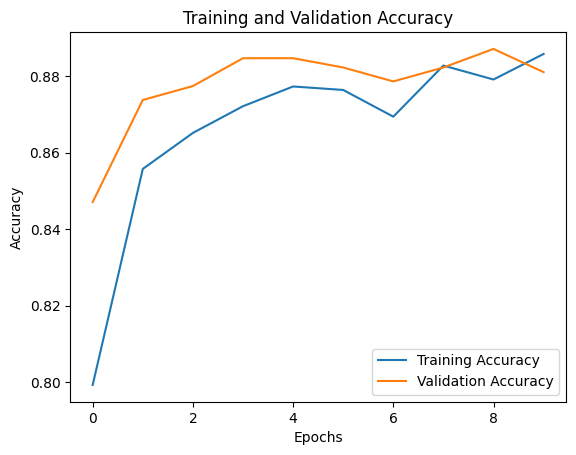

In [169]:

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

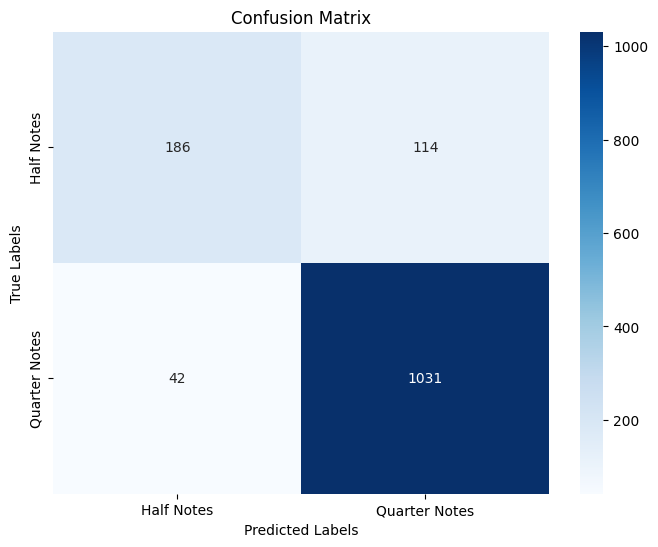

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Half Notes', 'Quarter Notes'], yticklabels=['Half Notes', 'Quarter Notes'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
